In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import sqrt
from datetime import datetime, timedelta,date
import seaborn as sns
from sklearn.metrics import mean_squared_error
#importing machine learning libraries
import pickle
import gc # to free some space from the memory
from sklearn.model_selection import KFold


#importing regressors
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor 
from xgboost import plot_importance
from lightgbm import plot_importance
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB


from sklearn.feature_selection import SelectFromModel

#ignoring warnings
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import GridSearchCV

# time seires staff
import statsmodels.api as sm
import itertools
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic

plt.style.use('ggplot') # plots style
# fixing the seed so that the code is reproduceable
random_state = 1

In [ ]:
# Reading Data
item_categories = pd.read_csv("../input/translated/item_categories-translated.csv")
items = pd.read_csv("../input/translated/items-translated.csv")
sales = pd.read_csv("../input/competitive-data-science-predict-future-sales/sales_train.csv")
shops = pd.read_csv("../input/translated/shops-translated.csv")
test = pd.read_csv("../input/competitive-data-science-predict-future-sales/test.csv")

Let's take a look on the data

In [ ]:
print("----------Shape of Data----------")
print(sales.shape)
print("----------first 5 rows----------")
print(sales.head(5))
print("-----------data frame overview-----------")
print(sales.info())
print("----------Missing value-----------")
print(sales.isnull().sum())

1) Date 

In [ ]:
# changing the type of the column into date time, this will ease future feature engineering
sales.date = pd.to_datetime(sales.date)
print("First date --> " , sales.date.min())
print("Last date --> " , sales.date.max())

2) date_block_num

In [ ]:
#what is the number of items soled at each month ?
sales_grouped_by_month =  sales.groupby('date_block_num')['item_cnt_day'].sum()
plt.figure(figsize=(15,8))
plt.title("Number of items sold by each month")
plt.xlabel("Date_block_num")
plt.ylabel("Items_sum")
sns.lineplot(data = sales_grouped_by_month)

3) shop_id

In [ ]:
print("Nuumber of shops is : ",sales.shop_id.nunique())

In [ ]:
# what is the number of items soled at each shop ?
items_ordered_grouped_by_shop =  sales.groupby('shop_id')['item_cnt_day'].sum()
plt.figure(figsize=(20,8))
plt.title("Number of items sold by each shop")
plt.xlabel("shop_id")
plt.ylabel("Items_mean")
sns.barplot(x = sales.shop_id.unique(),y =  items_ordered_grouped_by_shop )

There is a significant difference between the shops in terms number of ordered items.

4) item_id

In [ ]:
#number of unique items
print(sales.item_id.nunique())
best_5_items = sales.groupby("item_id")['item_cnt_day'].sum().sort_values(ascending = False ).head(5)
items_info = items[items.item_id.isin(best_5_items.index)].sort_values(by = 'item_id')
items_info

In [ ]:
plt.figure(figsize = (20,8))
plt.title("Most 5 items ordered")
plt.xlabel("Item Name")
plt.ylabel("Number of ordered items")
sns.barplot(x = items_info.item_name_translated.values , y = best_5_items.values)

This is a big number compared to the other !

5) item_price

In [ ]:
print(sales.item_price.describe().round(2))
plt.figure(figsize = (20 , 8))
sns.boxplot(sales.item_price)

removing high and negative prices 

In [ ]:
len(sales[sales.item_price > 25000] )/len(sales)

In [ ]:
sales = sales[(sales.item_price > 0) & (sales.item_price <= 25000)]

In [ ]:
print(sales.item_price.describe().round(2))
plt.figure(figsize = (20 , 8))
sns.boxplot(sales.item_price)

6) item_cnt_day (target variable):

In [ ]:
print(sales.item_cnt_day.describe().round())
plt.figure(figsize = (20 , 8))
sns.boxplot(sales.item_cnt_day)

# Time series forcating

# Arima ( AutoRegressive Integrated Moving Average )

In [ ]:
ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16,8))
plt.title('Total Sales by month')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts);

There is a clear trend and seasonality in the data let's look in more details by making decomposition. It's an additive model as the frequency and amplitude is not changing over time.

In [ ]:
decomp = sm.tsa.seasonal_decompose(ts.values , freq = 12 ,model = 'additive' )
fig = decomp.plot()

To use Arima the data must be stationary, i will make Augmented dicky fuller test to check stationarity there are other tests but this is the most popular.

In [ ]:
def ADF_test(ts) :
    df_test = adfuller(ts , autolag = "AIC")
    df_output = pd.Series(df_test[0:4] , index = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    print(df_output)

In [ ]:
ADF_test(ts)

In [ ]:
# create a differenced series
def difference(dataset, interval=1):
    diff = []
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

# invert the series to the original scale
def inverse_difference(last_ob, value):
    return value + last_ob

In [ ]:
stationary_ts = difference(ts)
ADF_test(stationary_ts)

The data is stationary now, only best parameter values left and arima has 3 parameters: (p, d, q). These three parameters account for seasonality, trend, and noise. plus another 3 parameters (P,D,Q) which are the same but for inserting the seasonaloity with us and using SARIMA.

In [ ]:
p = d = q = range(0, 2) # taking values 0 , 1 , 2 respectively 
pdq = list(itertools.product(p, d, q)) #combine them in a list
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq] #seasonal parameters will take all combinations of (0,1,2) 
# 12 is the time spane of repeating the seasonal pattern it could be differnt but i just choosed to make it 12 for simplicity

In [ ]:
# I will use grid search to find the optimal set of parameters

aic = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(stationary_ts,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            )
            results = mod.fit()
            aic.append(results.aic)
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
print(min(aic))

`(0, 1, 1)x(1, 1, 0, 12)` are best paramaters with the least aic score `434.490322082242` Let's do it ...

In [ ]:
stationary_train = stationary_ts[0:27]
stationary_test = stationary_ts[27:33]
print('train: \n', stationary_train , '\n\n')
print('test: \n', stationary_test)

In [ ]:
# Fit the model on the stationary_train set
mod = sm.tsa.statespace.SARIMAX(stationary_train,
                                order=(0, 1, 1),
                                seasonal_order=(1, 1, 0, 12))
results = mod.fit()


We should always run model diagnostics to investigate any unusual behavior

In [ ]:
fig = results.plot_diagnostics(figsize=(15, 12))
diagnostigs = fig

diagnostics is not bad so we are good and continue

In [ ]:
yhat = results.predict(28, 33).tolist() # Predicting based on the stationary data
test = ts[28:34].tolist() # cinverting ti list to loop through it
yhat = [inverse_difference(test[i], yhat[i]) for i in range(len(yhat))]
yhat = pd.Series(yhat , index = ts[28:34].index) # converting it from list to a series to get the index 

In [ ]:
plt.figure(figsize = (12,6))
plt.plot(ts[0:28] , label='Train')
plt.plot(ts[28:34] , label='Test')
plt.plot(yhat , label='six-months ahead Forecast')
plt.xlabel('Date block num')
plt.ylabel('number of items sold')
plt.legend()
plt.show()
rmse = sqrt(mean_squared_error(ts[28:34],yhat))
print('RMSE: %.1f' % rmse , "\n")
print(ts.describe()[1:3].round())

In [ ]:
sales_ts = sales[sales.item_cnt_day <= 20]
sales_ts=sales_ts.groupby(["date_block_num" , 'shop_id'])["item_cnt_day"].sum()
sales_ts = pd.DataFrame(sales_ts.reset_index()) # converting it to a dataframe 
sales_ts = sales_ts.rename(columns = {'item_cnt_day':'item_cnt_month'}) # now we are working monthly
sales_ts

In [ ]:
decomp = sm.tsa.seasonal_decompose(sales_ts.item_cnt_month , freq = 12 ,model = 'additive' )
fig = decomp.plot()

In [ ]:
test_rows = int(len(sales_ts) * 0.2)
train = sales_ts[ :-test_rows]
test = sales_ts[- test_rows :]
print(train)
print(test)

In [ ]:
# I will use grid search to find the optimal set of parameters
aic = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(pd.Series(train.item_cnt_month),
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            )
            results = mod.fit()
            aic.append(results.aic)
            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
print(min(aic))

`(1, 0, 1)x(0, 1, 1, 12)`

In [ ]:
mod = sm.tsa.statespace.SARIMAX(train.item_cnt_month,
                                            order=(1,0,1),
                                            seasonal_order=(0,1,1,12)
                                           )
results = mod.fit()

In [ ]:
test

In [ ]:
yhat = results.predict(len(train)+2, len(sales_ts)+1).tolist() # Predicting based on the stationary data
yhat = pd.Series(yhat , index = test.index) # converting it from list to a series to get the index 

In [ ]:
len(yhat)

In [ ]:
len(test)

In [ ]:
plt.figure(figsize = (12,6))
plt.plot(train.item_cnt_month , label='Train')
plt.plot(test.item_cnt_month , label='Test')
plt.plot(yhat , label='six-months ahead Forecast')
plt.xlabel('Date block num')
plt.ylabel('number of items sold')
plt.legend()
plt.show()
rmse = sqrt(mean_squared_error(test.item_cnt_month,yhat))
print('RMSE: %.1f' % rmse , "\n")
print(test.item_cnt_month.describe()[1:3].round())

# Machine learning

# Starting with a base model

In [ ]:
# Getting ready for the base model
sales.date = pd.to_datetime(sales.date)
sales['year'] = sales.date.dt.year

base = sales.copy() # leaving the original dataset untouched
base = pd.DataFrame(base.groupby(['date_block_num','shop_id','year','item_id'])['item_cnt_day'].sum())
base = base.reset_index() 
base = base.rename(columns = {'item_cnt_day':'item_cnt_month'})
base

In [ ]:
def get_data_splits(df) :
    """
    Splits a dataframe into 90% train, 10% validation but first order by the date_block_num. 
    
    """
    df = df.sort_values(by = 'date_block_num') #sort values by the date_clock_num so that the test set is the last period of time
    train = df[df.date_block_num < 32]
    validation = df[df.date_block_num > 31] # taking the last 2 months to simulate the test set 
    return train, validation

In [ ]:
train, validation = get_data_splits(base)

In [ ]:

X_train = train.drop('item_cnt_month' , axis = 1)
y_train = train.item_cnt_month

X_val = validation.drop('item_cnt_month' , axis = 1)
y_val = validation.item_cnt_month


models = []
models.append(('LGBM',LGBMRegressor(n_jobs = -1 , random_state = random_state)))
models.append(('XGB' , XGBRegressor(n_jobs= -1 ,random_state = random_state)) )
models.append(('RF' ,RandomForestRegressor(verbose = False ,random_state = random_state) ))
models.append(('LR' ,LinearRegression() ))
for name, model in models :
    model.fit(X_train, y_train)
    rmse = sqrt( mean_squared_error(model.predict(X_val), y_val ) ) 
    print(name ,": ",rmse )


These are the values of the base model and will be improved after every part in the notebook

LGBM :  16.25462807143281

XGB :  16.135782269473

RF :  14.926916180602934

LR :  16.547247380574465

In [ ]:
# i want to insert in the first position the date_block_num to match the test with the train
test = pd.read_csv("../input/competitive-data-science-predict-future-sales/test.csv")
test.insert(0 , 'date_block_num' , [34 for i in range(0, len(test) )])
test = test.drop('ID' , axis= 1)
test['year'] = 2015
test

In [ ]:
# submitting to the leaderboard
xgb = XGBRegressor(verbose = False , ,random_state = random_state)
xgb.fit(base.drop('item_cnt_month',axis = 1), base.item_cnt_month)
preds_xgb = xgb.predict(test)
sub = sample_submission
sub.item_cnt_month = preds_xgb
sub.to_csv('sub.csv' , index = False)

I got about 6 RMSE with the base model

# Feature Engineering

In [ ]:
sales1 = base.copy() # Continue on the base model

In [ ]:
# removing duplicate rows 
sales1.drop_duplicates(inplace = True , keep = 'first')

In [ ]:
# what is the portion of data that has target variable value with more than 20
round((len(sales1[sales1.item_cnt_month > 20]) / len(sales1)),3)


item_cnt_day has natural ouliers with values more than 20 and although they represent the real life but they are not a lot and make a lot of niose to the model so i will trim any value more than 20 and we will lose a small fraction of the data anyways



In [ ]:
sales1 = sales1[sales1.item_cnt_month <= 20]
print(sales1.item_cnt_month.describe().round())
plt.figure(figsize = (20 , 8))
sns.boxplot(sales1.item_cnt_month)
plt.show()

In [ ]:
# how many value in the target variable less than zero
print(len(sales1[sales1.item_cnt_month < 0 ]))
print(len(sales1[sales1.item_cnt_month < 0 ]) / len(sales1))

I will remove the negative values as they will cause noise on the data

In [ ]:
sales1 = sales1[sales1.item_cnt_month > 0]

Testing the model performance after trimming all values greater than 20 and less than 0

In [ ]:
# Validating after trimming the target variabel
train, validation = get_data_splits(sales1)
X_train = train.drop('item_cnt_month' , axis = 1)
y_train = train.item_cnt_month

X_val = validation.drop('item_cnt_month' , axis = 1)
y_val = validation.item_cnt_month


models = []
models.append(('XGB' , XGBRegressor(n_jobs= -1 , random_state = random_state)) )
models.append(('LGBM' ,LGBMRegressor( random_state = random_state) ))
for name, model in models :
    model.fit(X_train, y_train)
    rmse = sqrt( mean_squared_error(model.predict(X_val), y_val ) ) 
    print(name ,": ",rmse )

XGB :  1.9368071858443434

LGBM :  1.8915577818949325

Trimming the target variable improved the performance a lot on the validation data

Since the results of lightGBM and XGB are very similar but light gbm is much much faster i will continue using lightgbm

In [ ]:
# refitting on the full data and see the impact
lgbm = LGBMRegressor( n_jobs = -1 , random_state = random_state)
lgbm.fit(sales1.drop(['item_cnt_month'],axis = 1), sales1.item_cnt_month)

# saving the model in order to run it again witout taking so much time
file_name = 'lgbm_after_trimming.sav'
pickle.dump(lgbm , open(file_name, 'wb'))


In [ ]:
# submitting in the leaderboard
# load the file from the disk
lgbm = pickle.load(open('/content/lgbm_after_trimming (1).sav', 'rb'))
test = test[sales1.drop('item_cnt_month',axis = 1).columns] # sorting column names in the same order
preds = lgbm.predict(test)
sub = sample_submission
sub.item_cnt_month = preds
sub.to_csv('lgbm_after_trimming.csv' , index = False)

In [ ]:
lgbm = pickle.load(open('/content/lgbm_after_trimming (1).sav', 'rb'))
# ploting the importance
plot_importance(lgbm)

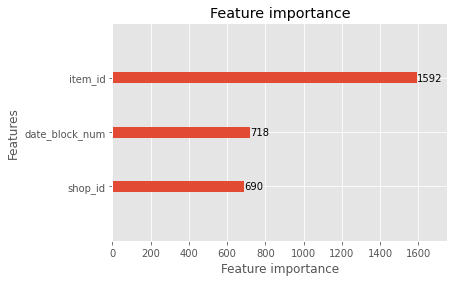

# Mean Encoding

`Motivation` : the item_id is not ordinal and if we one hot encoded it we will fall in the curse of dimensionality hence mean encoding is needed to solve this trap.

In [ ]:
from itertools import product # to make cartisien product
index_cols = ['shop_id' , 'item_id' , 'date_block_num']
grid = []
for block_num in sales.date_block_num.unique() : # iterating over the 34 month
    curr_shops = sales[sales.date_block_num == block_num]['shop_id'].unique() # get the unique shops in this month
    curr_items = sales[sales.date_block_num == block_num]['item_id'].unique() # get the unique items in this month
    grid.append(np.array(list(product (*[ curr_shops, curr_items, [block_num]]))))
grid = pd.DataFrame(np.vstack(grid) , columns = index_cols ) 
all_data = grid.merge(sales1[['shop_id' , 'item_id' , 'date_block_num','item_cnt_month']] , how = 'left' , on = index_cols).sort_values(index_cols).fillna(0) #to add the item_cnt_month
all_data

In [ ]:
def downcasting(df) :
    """
    make 2 lists onc contains index of float64 columns and the other int64 or int32,
    then change the dtype of these column into less memory consumer data type
    """
    float_cols = [ col for col in df if df[col].dtype == "float64" ]
    int_cols = [col for col in df if df[col].dtype in ['int64','int32']]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    return df

In [ ]:
# reducing memory usage
all_data = downcasting(all_data)
all_data.item_cnt_month = all_data.item_cnt_month.astype('int16')
all_data.info()

adding category_id to mean encode it

In [ ]:
# for each item_id put the item_category_id
all_data = all_data.merge(items[['item_id','item_category_id']] ) 
test = test.merge(items[['item_id','item_category_id']])
all_data

In [ ]:
all_data.isna().sum() # no nulls and every thing is right

working with item category

In [ ]:
item_categories

In [ ]:
all_data = all_data.merge(item_categories) # getting the item_category_name
test = test.merge(item_categories) # getting the item_category_name 

#extracting the main_category and sub_category
all_data['main_category'] = all_data.item_category_name_translated.str.split('-').map(lambda x: x[0].strip()) 
all_data['sub_category'] = all_data.item_category_name_translated.str.split('-').map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())

test['main_category'] = test.item_category_name_translated.str.split('-').map(lambda x: x[0].strip()) 
test['sub_category'] = test.item_category_name_translated.str.split('-').map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())


working with shop name

In [ ]:
shops.shop_name_translated.unique()[:10]

the shop name starts with a city name

In [ ]:
all_data = all_data.merge(shops) #adding shop_name
all_data['city'] = all_data.shop_name_translated.str.split(' ').map(lambda x : x[0]) #the first word is a city name

test = test.merge(shops) #adding shop_name
test['city'] = test.shop_name_translated.str.split(' ').map(lambda x : x[0]) #the first word is a city name

adding the year and month

In [ ]:
all_data['year'] = all_data['date_block_num'].map(lambda x : 2013 if x < 12 else 2014 if x < 24 else 2015)
test['year'] = 2015

In [ ]:
all_data['month'] = all_data['date_block_num'] % 12
test['month'] = test['date_block_num'] % 12

Working with regularized mean encoding in order to decrease the leakage

In [ ]:
# encoding item_id, category_id, shop_id
kf = KFold(n_splits = 5 , shuffle = False)
for train_ind, val_ind in kf.split(all_data) :
    train_data , val_data = all_data.iloc[train_ind], all_data.iloc[val_ind]
    all_data.loc[all_data.index[val_ind] , 'item_target_enc'] = val_data['item_id'].map(train_data.groupby('item_id')['item_cnt_month'].mean())
    all_data.loc[all_data.index[val_ind] , 'category_target_enc'] = val_data['item_category_id'].map(train_data.groupby('item_category_id')['item_cnt_month'].mean())
    all_data.loc[all_data.index[val_ind] , 'shop_target_enc'] = val_data['shop_id'].map(train_data.groupby('shop_id')['item_cnt_month'].mean())
    all_data.loc[all_data.index[val_ind] , 'city_target_enc'] = val_data['city'].map(train_data.groupby('city')['item_cnt_month'].mean())
    all_data.loc[all_data.index[val_ind] , 'main_category_target_enc'] = val_data['main_category'].map(train_data.groupby('main_category')['item_cnt_month'].mean())
    all_data.loc[all_data.index[val_ind] , 'sub_category_target_enc'] = val_data['sub_category'].map(train_data.groupby('sub_category')['item_cnt_month'].mean())
    all_data.loc[all_data.index[val_ind] , 'year_target_enc'] = val_data['year'].map(train_data.groupby('year')['item_cnt_month'].mean())
    all_data.loc[all_data.index[val_ind] , 'month_target_enc'] = val_data['month'].map(train_data.groupby('month')['item_cnt_month'].mean())

all_data.fillna(all_data.item_cnt_month.mean(), inplace=True) # fill na that happend from values in validation not in the train with the global mean    

In [ ]:
# making a column to map item_target_enc to the test set
item_mean_enc = all_data.groupby('item_id')['item_target_enc'].unique()
item_mean_enc = item_mean_enc.apply(lambda x: x.mean())
test['item_target_enc'] = test['item_id'].map(item_mean_enc) # mapping the variable in the test 

# making a column to map item_category_id to the test set
category_mean_enc = all_data.groupby('item_category_id')['category_target_enc'].unique()
category_mean_enc = category_mean_enc.apply(lambda x: x.mean())
test['category_target_enc'] = test['item_category_id'].map(category_mean_enc) # mapping the variable in the test 

# making a column to map the shop_target_enc to the test set
shop_mean_enc = all_data.groupby('shop_id')['shop_target_enc'].unique()
shop_mean_enc = shop_mean_enc.apply(lambda x: x.mean())
test['shop_target_enc'] = test['shop_id'].map(shop_mean_enc) # mapping the variable in the test 


In [ ]:
# mapping city
city_mean_enc = all_data.groupby('city')['city_target_enc'].unique()
city_mean_enc = city_mean_enc.apply(lambda x: x.mean())
test['city_target_enc'] = test['city'].map(city_mean_enc) # mapping the variable in the test 

# mapping sub_category
sub_category_mean_enc = all_data.groupby('sub_category')['sub_category_target_enc'].unique()
sub_category_mean_enc = sub_category_mean_enc.apply(lambda x: x.mean())
test['sub_category_target_enc'] = test['sub_category'].map(sub_category_mean_enc) # mapping the variable in the test 

# mapping main_category
main_category_mean_enc = all_data.groupby('main_category')['main_category_target_enc'].unique()
main_category_mean_enc = main_category_mean_enc.apply(lambda x: x.mean())
test['main_category_target_enc'] = test['main_category'].map(main_category_mean_enc) # mapping the variable in the test 

In [ ]:
# mapping year
year_mean_enc = all_data.groupby('year')['year_target_enc'].unique()
year_mean_enc = year_mean_enc.apply(lambda x: x.mean())
test['year_target_enc'] = test['year'].map(year_mean_enc) # mapping the variable in the test 

# mapping month
month_mean_enc = all_data.groupby('month')['month_target_enc'].unique()
month_mean_enc = month_mean_enc.apply(lambda x: x.mean())
test['month_target_enc'] = test['month'].map(month_mean_enc) # mapping the variable in the test 

test.fillna(all_data.item_cnt_month.mean() , inplace = True)


droping the category name and shop name

In [ ]:
all_data.drop(['item_category_name_translated','shop_name_translated'],axis = 1, inplace = True)
test.drop(['item_category_name_translated','shop_name_translated'],axis = 1, inplace = True)

In [ ]:
all_data.head()

seeing the importance of the added features

In [ ]:
# submitting in the leaderboard
lgbm = pickle.load(open('/content/lgbm_mean_encoding.sav', 'rb'))
test = test[all_data.drop('item_cnt_month',axis = 1).columns] # sorting the columns
preds_lgbm = lgbm.predict(test.drop(['city','main_category','sub_category'],axis = 1))
sub = sample_submission
sub.item_cnt_month = preds_lgbm
sub.to_csv('lgbm_mean_encoding.csv' , index = False)

In [ ]:
# ploting the importance
lgbm = pickle.load(open('/content/lgbm_mean_encoding.sav', 'rb'))
plt.style.use('ggplot')
ax = plot_importance(lgbm)
fig = ax.figure
fig.set_size_inches(9, 13)


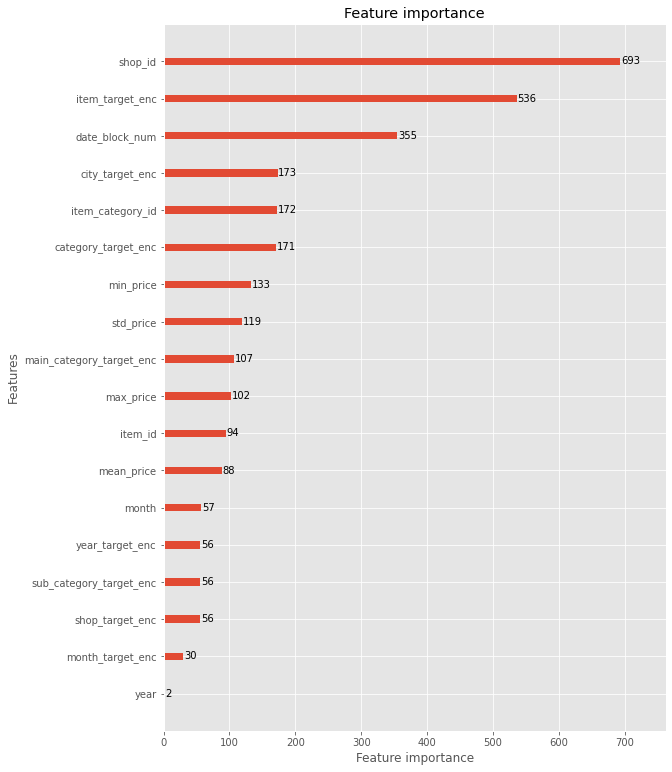

Mean encodnig improved the model performance the RMSE is about `1.25`

working with the price 

In [ ]:
item_prices = pd.DataFrame(sales.groupby('item_id')['item_price'].unique()).reset_index()
item_prices

In [ ]:
# taking different statictical measurements of the price
item_prices['mean_price'] = item_prices.item_price.apply(lambda p : np.mean(p))

In [ ]:
item_prices

adding mean_price and removing item_price

In [ ]:
all_data = all_data.merge(item_prices.drop('item_price',axis = 1) , how = 'left' , on = 'item_id')
test = test.merge(item_prices.drop('item_price',axis = 1) , how = 'left' , on = 'item_id')
all_data.head()

In [ ]:
test.isna().sum() # let's see if there are any nulls

In [ ]:
len([i for i in test.item_id.unique() if i not in sales.item_id.unique()]) # how many item_id is in the test and not in the train

In [ ]:
test.item_id.nunique()

there are `366` out of `5100` unique test item_id not in the train data so i will impute them with the category_id_mean_price

I will impute the missing prices with the mean price of the category of that item

In [ ]:
# for each category get its mean price
category_mean_prices = pd.DataFrame(all_data.groupby('item_category_id')['mean_price'].mean()).reset_index()
category_mean_prices

In [ ]:
dic = {} # making a dictionary wehere each item_category correspond to mean value of that category
for i in category_mean_prices.item_category_id.unique() :
  dic[i] =category_mean_prices[category_mean_prices.item_category_id == i]['mean_price'].values[0]
dic

In [ ]:
# now get the index of the items that do not have prices and impute with the made dictionary
ind = test[test.mean_price.isna()].index
for i in ind :
  test.loc[i , 'mean_price'] = dic[test.loc[i , 'item_category_id']]
  
# there are no nulls now

# Adding lags

In [ ]:
# train lags for shop_id and item_id
lag_list = [1, 2, 3,4,5,12 ]

for lag in lag_list:
    ft_name = ('item_shop_lag_%s' % lag)
    all_data[ft_name] = all_data.sort_values('date_block_num').groupby(['shop_id','item_id'])['item_cnt_month'].shift(lag)
    # Fill the empty shifted features with 0
    all_data[ft_name].fillna(0, inplace=True)

adding the lags to the test data

In [ ]:
# for the shop_id - item_id lags
def get_test_lags_shop(all_data , test, lag) :
    
    shifted = all_data[['date_block_num','shop_id','item_id', 'item_cnt_month']]
    shifted.columns = ['date_block_num','shop_id','item_id', 'item_shop_lag_'+ str(lag)]
    shifted['date_block_num'] -= lag
    test_lag = pd.merge(test, shifted, on=['date_block_num','shop_id','item_id'] , how = 'left')
    return test_lag['item_shop_lag_'+ str(lag)] #return the last column (the lags) 

In [ ]:
test_lags = test.copy() # taking a copy to experemint with
for lag in [1,2,3,4,5,12] :
    lag_values = get_test_lags_shop(all_data ,test_lags, lag)
    test_lags['item_shop_lag_'+ str(lag)] = lag_values
test_lags.fillna(0 , inplace = True) 

testing the lags impact

In [ ]:
lgbm = LGBMRegressor(verbose = 0 , n_jobs = -1,random_state = random_state)
lgbm.fit(all_data.drop(['item_cnt_month','city','main_category','sub_category'],axis = 1), all_data.item_cnt_month)

# saving the model in order to run it again witout taking so much time
file_name = 'lgbm_adding_lags.sav'
pickle.dump(lgbm , open(file_name, 'wb'))


In [ ]:
# submitting in the leaderboard
lgbm = pickle.load(open('/content/lgbm_adding_lags.sav', 'rb'))
preds_lgbm = lgbm.predict(test_lags.drop(['city','main_category','sub_category'],axis = 1))
sub = sample_submission
sub.item_cnt_month = preds_lgbm
sub.to_csv('lgbm_adding_lags.csv' , index = False)

RMSE : `1.25644`

In [ ]:
# plot importance
plt.style.use('ggplot')
ax = plot_importance(lgbm)
fig = ax.figure
fig.set_size_inches(9, 13)


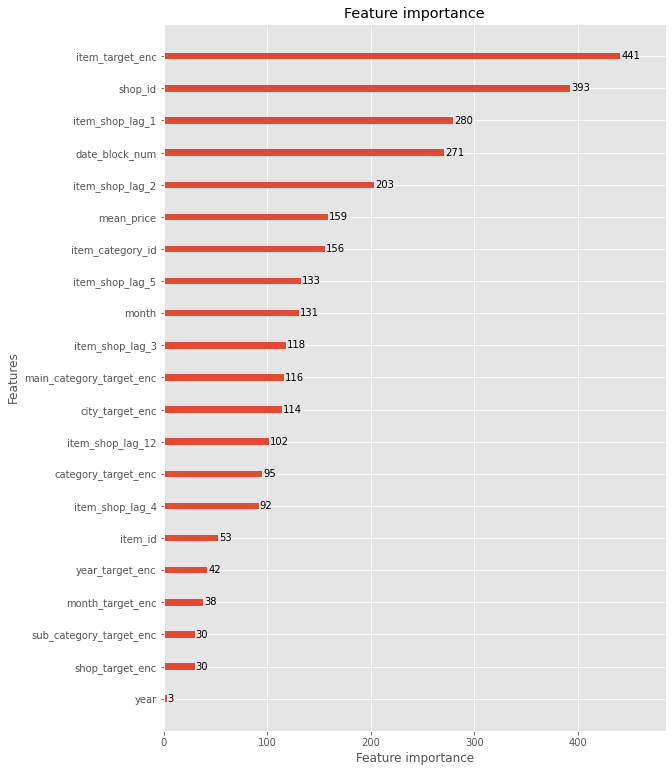

In [ ]:
all_data.shop_id = all_data.shop_id.astype('int8')
all_data.date_block_num = all_data.date_block_num.astype('int8')
all_data.item_cnt_month = all_data.item_cnt_month.astype('int8')
all_data.item_category_id = all_data.item_category_id.astype('int8')

adding interaction features with label encoding

In [ ]:
pd.factorize(['A','b','c','A'])[0]

In [ ]:
import itertools
cat_features= ['shop_id','item_id','mean_price','month']
# Iterate through each pair of 2 features, combine them into interaction features
all_combinations = list(itertools.combinations(cat_features, 2))
for combination in all_combinations: #for each pair of columns convert them to strings then join them with the + operator.
  interaction = all_data[combination[0]].map(str) + '_' + all_data[combination[1]].map(str)
  interaction_name = combination[0] + '_' + combination[1]

  all_data[interaction_name] = pd.factorize(interaction)[0] # return the interaction column label encoded directly


In [ ]:
# let's go back to test again
import gc
test = test_lags.copy()
del test_lags
gc.collect()

In [ ]:
for combination in all_combinations: #for each pair of columns convert them to strings then join them with the + operator.
  interaction = test[combination[0]].map(str) + '_' + test[combination[1]].map(str)
  interaction_name = combination[0] + '_' + combination[1]
  test[interaction_name] = pd.factorize(interaction)[0] # return the interaction column label encoded directly


In [ ]:
# we don't need them any more
all_data.drop(['city','main_category','sub_category'],axis = 1 , inplace = True)
test.drop(['city','main_category','sub_category'],axis = 1 , inplace = True)

In [ ]:
lgbm = LGBMRegressor(verbose = 0 , n_jobs = -1,random_state = random_state)
lgbm.fit(all_data.drop(['item_cnt_month'],axis = 1), all_data.item_cnt_month)

# saving the model in order to run it again witout taking so much time
file_name = 'lgbm_after_interactions.sav'
pickle.dump(lgbm , open(file_name, 'wb'))

In [ ]:
# submitting in the leaderboard
lgbm = pickle.load(open('/content/lgbm_after_interactions.sav', 'rb'))
test = test[all_data.drop('item_cnt_month' , axis = 1).columns] # sorting columns in the same order
preds_gbm = lgbm.predict(test)
sub = sample_submission
sub.item_cnt_month = preds_gbm
sub.to_csv('lgbm_all_features_updated.csv' , index = False)

RMSE `1.23940`

working on the lags

In [ ]:
all_data['sum_lags'] = all_data.item_shop_lag_1 + all_data.item_shop_lag_2 + all_data.item_shop_lag_3 + all_data.item_shop_lag_4 + all_data.item_shop_lag_5
all_data['mean_lags'] = (all_data.sum_lags/5)

test['sum_lags'] = test.item_shop_lag_1 + test.item_shop_lag_2 + test.item_shop_lag_3 + test.item_shop_lag_4 + test.item_shop_lag_5
test['mean_lags'] = (test.sum_lags/5)

In [ ]:
# validating that the calculation is right
all_data[all_data.item_cnt_month > 5][['item_cnt_month','item_shop_lag_1','item_shop_lag_2','item_shop_lag_3','item_shop_lag_4','item_shop_lag_5','sum_lags','mean_lags']]

In [ ]:
lgbm = LGBMRegressor(verbose = 0 , n_jobs = -1,random_state = random_state)
lgbm.fit(all_data.drop(['item_cnt_month'],axis = 1), all_data.item_cnt_month)
# saving the model in order to run it again witout taking so much time
file_name = 'working_with_lags.sav'
pickle.dump(lgbm , open(file_name, 'wb'))


In [ ]:
lgbm = pickle.load(open('/content/working_with_lags.sav', 'rb'))
preds_gbm = lgbm.predict(test)
sub = sample_submission
sub.item_cnt_month = preds_gbm
sub.to_csv('working_with_lags.csv' , index = False)

RMSE `1.25988`

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(lgbm.feature_importances_,test.columns) , reverse= True), columns=['Value','Feature'])
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp)
plt.title('LightGBM Features importance based on gain ')
plt.tight_layout()
plt.show()

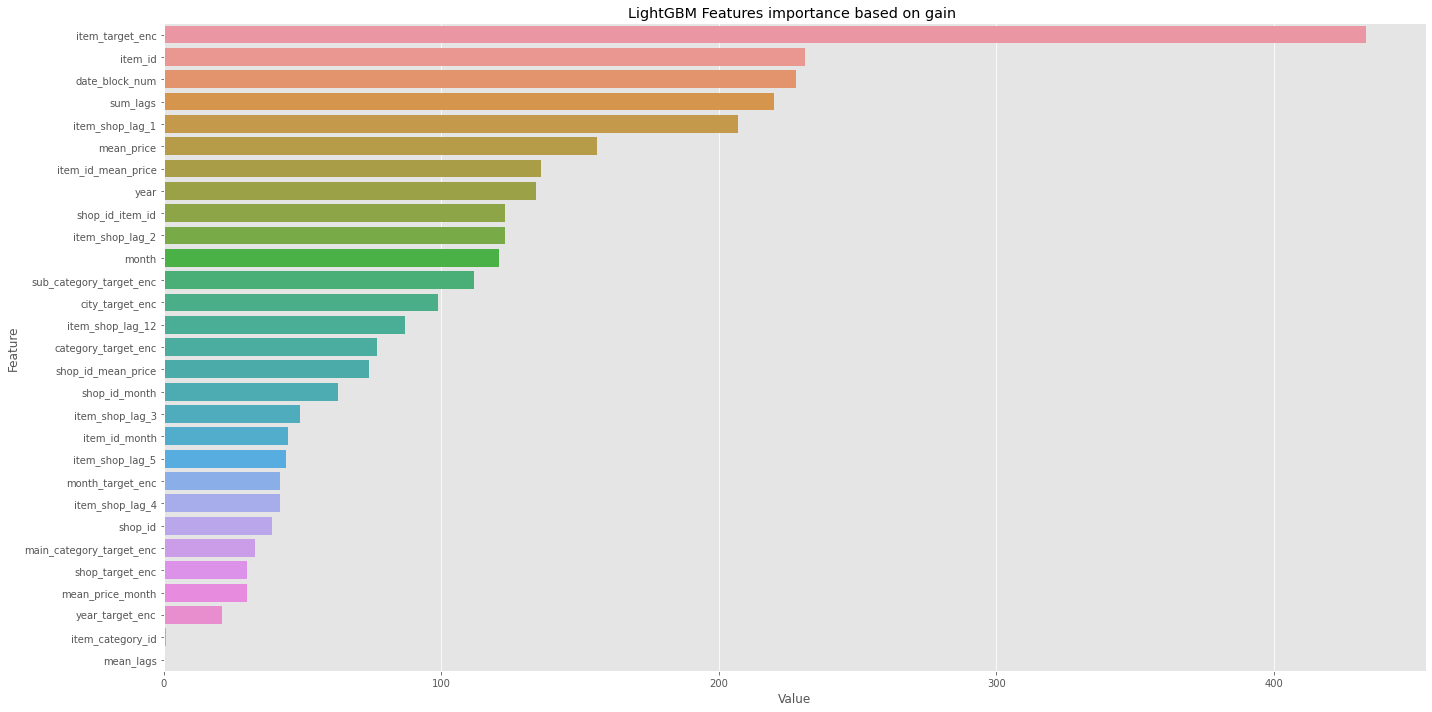

the RMSE is worst and the mean lags is not important at  all, but it will be handled in the feature selection

# Feature selection

In [ ]:
train = all_data[all_data.date_block_num < 31]
val = all_data[all_data.date_block_num >= 32]
train_X = train.drop('item_cnt_month' , axis = 1)
train_y = train.item_cnt_month
val_X = val.drop('item_cnt_month' , axis = 1)
val_y = val.item_cnt_month

In [ ]:
lgbm = LGBMRegressor(verbose = 0 , n_jobs = -1,random_state = random_state)
lgbm.fit(train_X,train_y)
# saving the model in order to run it again witout taking so much time
file_name = 'feature_selection.sav'
pickle.dump(lgbm , open(file_name, 'wb'))

I will use backawrd elimination method to select the features based on their gain importance 

the next cell will take a lot of time you can skip it and run the one after it

In [ ]:
lgbm_FS = pickle.load(open('/content/feature_selection.sav', 'rb')) # FS stands for feature selection and it will be used for selection

thresholds = sorted(lgbm_FS.feature_importances_ )[:20] # check the least 20 importance score  
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(lgbm_FS, threshold=thresh, prefit=True)
    select_train = selection.transform(train_X)
    # train model
    selection_model = LGBMRegressor(n_jobs = -1 , random_state = random_state)
    selection_model.fit(select_train, train_y )
        # eval model
    select_val = selection.transform(val_X)
    predictions = selection_model.predict(select_val)
    RMSE = sqrt(mean_squared_error(val_y, predictions))
    print("Thresh=%.3f, n=%d, RMSE: %.2f" % (thresh, select_train.shape[1], RMSE))


Thresh=0.000, n=29, RMSE: 0.76
Thresh=1.000, n=28, RMSE: 0.76
Thresh=12.000, n=27, RMSE: 0.76
Thresh=29.000, n=26, RMSE: 0.76
Thresh=32.000, n=25, RMSE: 0.77
Thresh=34.000, n=24, RMSE: 0.76
Thresh=42.000, n=23, RMSE: 0.76
Thresh=43.000, n=22, RMSE: 0.76
Thresh=43.000, n=22, RMSE: 0.76
Thresh=44.000, n=20, RMSE: 0.76
Thresh=48.000, n=19, RMSE: 0.76
Thresh=49.000, n=18, RMSE: 0.76
Thresh=54.000, n=17, RMSE: 0.77
Thresh=60.000, n=16, RMSE: 0.76
Thresh=68.000, n=15, RMSE: 0.77
Thresh=83.000, n=14, RMSE: 0.77
Thresh=101.000, n=13, RMSE: 0.77
Thresh=102.000, n=12, RMSE: 0.77
Thresh=112.000, n=11, RMSE: 0.77
Thresh=112.000, n=11, RMSE: 0.77

`Thresh=60.000, n=16, RMSE: 0.76` so i will use this thresh and select the best 16 feature

In [ ]:
lgbm_FS = pickle.load(open('/content/feature_selection.sav', 'rb')) # FS stands for feature selection and it will be used for selection
feature_imp = pd.DataFrame(sorted(zip(lgbm_FS.feature_importances_,test.columns) , reverse= True), columns=['Value','Feature'])

feature_imp = feature_imp[feature_imp.Value >= 60.000]
selected_cols = list(feature_imp['Feature'].values)
Final_train = all_data[selected_cols]
Final_test = test[selected_cols]
# adding item_cnt_month
Final_train['item_cnt_month'] = all_data['item_cnt_month']


testing the impact

In [ ]:
lgbm_after_selection = LGBMRegressor(verbose = 0 , n_jobs = -1,random_state = random_state)
lgbm_after_selection.fit(all_data.drop(['item_cnt_month'],axis = 1), all_data.item_cnt_month)

# saving the model in order to run it again witout taking so much time
file_name = 'after_selection.sav'
pickle.dump(lgbm_after_selection , open(file_name, 'wb'))

In [ ]:
lgbm_after_selection = pickle.load(open('/content/after_selection.sav', 'rb'))
preds_gbm = lgbm_after_selection.predict(test)
sub = sample_submission
sub.item_cnt_month = preds_gbm
sub.to_csv('after_selection.csv' , index = False)

RMSE `1.24497`

# hyper paramter tuning

i will use a single validation set to keep it simple and fast

In [ ]:
train = Final_train[Final_train.date_block_num < 33]
val = Final_train[Final_train.date_block_num == 33] # taking the last month to simulate the test set
X_train = train.drop('item_cnt_month',axis = 1)
y_train = train.item_cnt_month
X_val = val.drop('item_cnt_month',axis = 1)
y_val = val.item_cnt_month

1) Tuning number of leafs

In [ ]:
for num_leaves in [10,15,20,25,30,35,40,50] :

    lgbm = LGBMRegressor(random_state=random_state ,num_leaves= num_leaves)
    lgbm.fit(X_train,y_train)
    print("num_leaves : " , num_leaves, " RMSE : ", sqrt(mean_squared_error(lgbm.predict(X_val) , y_val)) ,'\n')

`num_leaves :  50  RMSE :  0.7731009500323047 ` is the best


2) Tuning bagging_fraction

In [ ]:
for fraction in [0.7,0.8,0.9] :

    lgbm = LGBMRegressor(random_state=random_state , num_leaves=50 , bagging_fraction = fraction)
    lgbm.fit(X_train,y_train)
    print("bagging_fraction : " , fraction, " RMSE : ", sqrt(mean_squared_error(lgbm.predict(X_val) , y_val)) ,'\n')

bagging_fraction :  0.7  RMSE :  0.7731009500323047 

bagging_fraction :  0.8  RMSE :  0.7731009500323047 

bagging_fraction :  0.9  RMSE :  0.7731009500323047 


`No difference`

4) Tuning feature_fraction

In [ ]:
for fraction in [0.7,0.8,0.9] :

    lgbm = LGBMRegressor(random_state=random_state ,num_leaves=50 , feature_fraction = fraction)
    lgbm.fit(X_train,y_train)
    print("feature_fraction : " , fraction, " RMSE : ", sqrt(mean_squared_error(lgbm.predict(X_val) , y_val)) ,'\n')

`feature_fraction :  0.9  RMSE :  0.7710114141411256 ` is the best



5) Tuning min_data_in_leaf

In [ ]:
# trying wide range first and then narrow the range
for value in [0,1,5,10,15,20,25,30,50,60] :

    lgbm = LGBMRegressor(random_state=random_state , num_leaves=50, feature_fraction = 0.9, min_data_in_leaf = value)
    lgbm.fit(X_train,y_train)
    print("min_data_in_leaf : " , value, " RMSE : ", sqrt(mean_squared_error(lgbm.predict(X_val) , y_val)) ,'\n')

` no improvments`

6) Tuning n_estimators based on small learning rate

In [ ]:
eval_set = [(X_val , y_val),(X_train,y_train)]
lgbm = LGBMRegressor(n_jobs= -1 , random_state= random_state ,n_estimators= 1000 , learning_rate= 0.02 , num_leaves=50,feature_fraction = 0.9)
lgbm.fit(X_train, y_train ,eval_set =eval_set, early_stopping_rounds=30 ) 

In [ ]:
plt.figure(figsize=(12,6))
results = lgbm.evals_result_
epochs = len(results['valid_0']['l2'])
x_axis = range(0, epochs)
# plot acuuracy
fig, ax = plt.subplots()
ax.plot(x_axis, results['training']['l2'], label='Train')
ax.plot(x_axis, results['valid_0']['l2'], label='validation')
ax.legend()
plt.ylabel('RMSE')
plt.title('LGBM RMSE')
plt.show()


Early stopping, best iteration is:
[917]	training's l2: `0.594811`	valid_0's l2: `0.590641`

see the impact on the test set

In [ ]:
AHPT_lgbm = LGBMRegressor(random_state = random_state  , learning_rate = 0.02 , n_estimators = 917,num_leaves = 50, feature_fraction = 0.9) # AHPT : After Hyper Paramater Tuning
AHPT_lgbm.fit(Final_train.drop(['item_cnt_month'],axis = 1),Final_train.item_cnt_month)

# save the model
filename = 'after_hyperparamater_tuning.sav'
pickle.dump(AHPT_lgbm,open(filename,'wb'))

In [ ]:
# load the model from the disk
AHPT_lgbm = pickle.load(open('/content/after_hyperparamater_tuning.sav','rb'))
AHPT_preds = AHPT_lgbm.predict(Final_test)
sub = sample_submission
sub.item_cnt_month = AHPT_preds
sub.to_csv('after_hyperparamater_tuning.csv' , index = False)

RMSE : `1.26008`

Surprisngly the RMSE is more than the one before hyper paramater tning mabye because the validation is not simulating the test set perfectly but any ways it's very small fraction that we can ignore

# Stacking

make test_level2 using :

1) linear regression ( linear algorithms)

2) lightgbm (ensamble with dependent trees)

3) knn (similarity measures)

4) naive_bais (bayesian algotithms)

A side note that i tried random forest and decision tree but the RAM was crashing so i removed them

In [ ]:
zeros_array = np.zeros(len(Final_test)) # to initiate the test_level2 with
test_level2 = pd.DataFrame({'lr':zeros_array,'lgbm':zeros_array,'knn':zeros_array,'nb':zeros_array})
test_level2

In [ ]:
# initiating the models
# fitting the models
# predicting and put the predictions in test_level2 data frame to test on it with the meta model

lr =  LinearRegression()
lr.fit(Final_train.drop(['item_cnt_month'],axis = 1),Final_train.item_cnt_month)
pred = lr.predict(Final_test)
test_level2['lr'] = pred


In [ ]:
knn= KNeighborsRegressor()
knn.fit(Final_train.drop(['item_cnt_month'],axis = 1),Final_train.item_cnt_month)
pred = knn.predict(Final_test)
test_level2['knn'] = pred

In [ ]:
nb = GaussianNB()
nb.fit(Final_train.drop(['item_cnt_month'],axis = 1),Final_train.item_cnt_month)
pred = nb.predict(Final_test)
test_level2['nb'] = pred

In [ ]:
lgbm = LGBMRegressor(random_state = random_state  , learning_rate = 0.02 , n_estimators = 917,num_leaves = 50, feature_fraction = 0.9) 
lgbm.fit(Final_train.drop(['item_cnt_month'],axis = 1),Final_train.item_cnt_month)
pred = lgbm.predict(Final_test)
test_level2['lgbm'] = pred

In [ ]:
# taking all the dates we have to make conditions on it
dates = Final_train.date_block_num
# this validation_dates will help me making conditions as you will see next
validation_dates = Final_train[dates.isin([24,25,26,27,28])].date_block_num

In [ ]:
# And here we create 2nd level feeature matrix, init it with zeros first
validation_size = len(Final_train[dates.isin([24,25,26,27,28])])
zeros_array = np.zeros(validation_size )
X_train_level2 = pd.DataFrame({'lr':zeros_array,'lgbm':zeros_array,'knn':zeros_array,'nb':zeros_array , 'dates':validation_dates})

# making the y_train
Final_train_sub = Final_train.loc[dates >  23]
y_train_level2 = Final_train_sub.item_cnt_month

In [ ]:
models = []
models.append(('lr', LinearRegression()))
models.append(('lgbm',LGBMRegressor(random_state = random_state  , learning_rate = 0.02 , n_estimators = 71,num_leaves = 10)))
models.append(('knn', KNeighborsRegressor()))
models.append(('nb', GaussianNB()))


In [ ]:
# Now fill `X_train_level2` with metafeatures
for cur_block_num in [28,29,30,31,32]:
    
    print(cur_block_num)
     
    # 1. Split `X_train` into parts
    X = Final_train.loc[dates <  cur_block_num].drop('item_cnt_month', axis=1)
    y= Final_train.loc[dates < cur_block_num, 'item_cnt_month']
    X_test = Final_train.loc[dates ==  cur_block_num].drop('item_cnt_month', axis=1)
    
    
    for name, model in models : # i'm using cross validation but with respect to time and this is done for each model in the 4
        model.fit(X,y)
        pred = model.predict(X_test)
        X_train_level2.loc[X_train_level2.dates == cur_block_num ,name] = pred

now the meta model will fit on X_train_level2 and predict on test_level2.


I will get the best paramaters using Randomgridsearch with 4 folds

In [ ]:
# 2) lighgbm with randomGridSearch on 4 folds

# Define our search space for grid search
search_space = [
  {
               'feature_fraction': [0.7,0.8,0.9,1],
                'n_estimators': [100,150,200,250,300,350,400,450,500,600,700],
               'min_data_in_leaf': [0,1,5,10,50,100,200], 
               'bagging_fraction': [0.7,0.8,0.9,1], 
               'learning_rate': [0.01,0.02], 
               'num_leaves': [1,2,3,4,5,10,15,20,25,30],
               'verbose':[0]
  }
]
# Define cross validation
kfold = StratifiedKFold(n_splits=4, random_state=random_state)
# Define grid search
random_grid = RandomizedSearchCV(
  LGBMRegressor(),
  param_distributions=search_space,
  cv=kfold,
  scoring='neg_root_mean_squared_error',
  verbose=1,
  n_jobs=-1,
  refit = True
)


In [ ]:
random_grid.fit(X_train_level2.drop('dates',axis = 1) , y_train_level2)

# save the model
filename = 'meta_lgbm.sav'
pickle.dump(random_grid,open(filename,'wb'))

preds = random_grid.predict(test_level2)
sub = sample_submission
sub.item_cnt_month = preds
sub.to_csv('meta_lgbm.csv' , index = False)

RMSE : `1.21`